# MCMC and the Metropolis-Hastings Algorithm

> This tutorial gives a brief introduction to Approximate Bayesian Inference via Markov Chain Monte Carlo.
> 
> Author: Bjarne C. Hiller

## The Observation

Great news, everyone! We just made a new observation $x$!

![Good news, everyone!](figures/good_news_everyone.jpeg)

We know, that this observation $x$ was generated by a process that depends on another variable - let's call it $z$.
Unfortunately, we cannot observe $z$ directly - it is hidden (latent).
Can we *infer* some information about the latent variable $z$ from the observation $x$ we made?

Yes, using probability theory and *Bayes' law*, we know that:

$$
    \underbrace{p(z|x)}_\text{posterior} = \frac{ \overbrace{p(x|z)}^\text{likelihood} \cdot \overbrace{p(z)}^\text{prior}}{ \underbrace{p(x)}_\text{evidence}}
$$

We are interested in the probability distribution $p(z|x)$, i.e., the probability of $z$, *posterior* to observing $x$.
This problem is known as *Bayesian inference*.

Alright, the equation seems straightforward enough - so, where is the catch?

## The Catch

Let's say we just define the distribution $p(z)$ from our assumptions *prior* to observing $x$ - a uniform distribution seems reasonable enough!
Then, we describe the process which generates $x$ from $z$, providing us implicitly with the *likelihood* $p(x|z)$: information, how *likely* $x$ is given $z$.

But now it get's tricky: How do we actually know the probability of observing *evidence* $x$? We could observe some more instantiations of $x$, and estimate the density of $x$. But depending on the density and structure of $x$, it could require a ton of observations to guarantee that our approximation gets atleast somewhat close to the true density - especially, if there is a chance for very rare events.

Alternatively, we could just compute $p(x)$ from the likelihood and the prior, which we already have - because we defined them ourselves. How convenient!

Using the definition of conditional probabilites, for a single discrete variable $p(z)$ with $i$ possible values, Bayes' Law then would transform into:

$$
    p(z|x) = \frac{p(x|z) \cdot p(z)}{\color{red}p(x)}
    = \frac{p(x|z) \cdot p(z)}{ \color{red} \sum_i p(x|z_i) p(z_i)}
$$

Great, so this is something we could just compute by iterating over z and summing up the individual values!

However, if we're dealing with a latent *continuous random variable* $z$, i.e., with values from a continuous domain, we need to put more effort in and integrate over $z$ instead.
Additionally, we might be even looking at a vector of latent variables latent variables $\bm{z}=[z_1, z_2, ..., z_k]^T$, which results in ugly, nested integrals...

Then, the computation becomes *intractible*. Or, simply put: it takes very, *very* long to compute.

$$
    p(z|x) = \frac{p(x|z) \cdot p(z)}{\color{red}p(x)}
    = \frac{p(x|z) \cdot p(z)}{ \color{red}\underbrace{ \int{ p(x|z) p(z)}dz}_\text{intractible!}}
$$

## The Solution

Since we are very, *very* impatient, we don't want to wait for our inferred posterior probability $p(z|x)$.
Maybe, we don't actually need the result to be *too* accurate - then, we can sacrifice precision against speed!

This is known as *Approximate Bayesian Inferrence*, and historically, there are two main approaches to it:

### 1. Variational Inference (cool: VI)

Variational Inference methods usually restricts the posterior to be a distribution from a family of probability distributions - for example, a Normal distribution. This reduces the problem from computing the density $p(z|x)$ on the complete domain to just estimating the parameters (like mean and variance) of the posterior distribution. Usually, the parameters are optimized by maximizing an objective function, like the *Evidence Lower Bound* (cool: ELBO), e.g., via gradient descent. Since those methods perform inference by finding the maximum of an objective function, they are called *variational* (see [calculus of variations](https://en.wikipedia.org/wiki/Calculus_of_variations)). You might have also already heard of *Variational Autoencoders*? Their latent representations describe parameters of a posterior distribution, so the encoder actually learns to perform Variational Inference.

### 2. Markov Chain Monte Carlo (cool: MCMC)

A *Monte Carlo* algorithm usually finds an approximation of the result by sampling from a random process.
The name *Monte Carlo* was introduced by [Stanisław Ulam](https://en.wikipedia.org/wiki/Stanis%C5%82aw_Ulam), referencing the Monte Carlo Casino in Monaco and the gambling nature of the algorithm.
Similarly, Markov Chain Monte Carlo algorithms approximate a distribution by repeatly taking random steps in a Markov Chain.
The approximation of the density usually becomes more accurate with the number of steps, i.e., the length of the chain.
Therefore, MCMC allows sampling from probability distributions, even if the density function of the distribution itself isn't known.

MCMC methods can be used for Approximate Bayesian Inference by sampling from the posterior distribution.



In the remainder of this tutorial, we will implement a simple version of the *Metropolis-Hastings Algorithm*, which allows us to sample from the posterior distribution.

## Implementation

### Setting

In our scenario, we observed values for a random variable $x \in \mathbb{R}$.
We know, that x is generated by a normal distribution $x \sim \mathcal{N}(z, 1)$ with a scale of 1, and an unknown mean, which is our latent variable $z$.

Our *prior* assumption is, that $z$ itself is normal distributed $z \sim \mathcal{N}(0,1)$.

Let's generate some new observation data from the *true* data distribution $\mathcal{N}(0.1,1)$:

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from tqdm import trange

rng = np.random.default_rng(19)


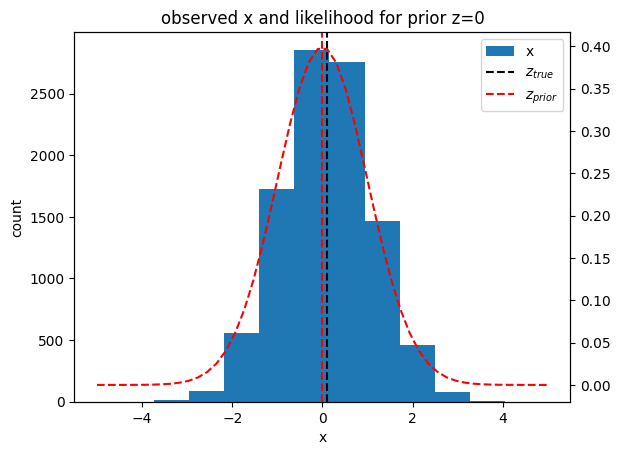

In [2]:
N = 10_000

Z_PRIOR = 0
SIGMA_PRIOR = 1
Z_TRUE = 0.1

def get_data(n):
    return rng.normal(Z_TRUE, 1, n)

x = get_data(N)

plt.hist(x, label="x")
plt.axvline(Z_TRUE, color="k", linestyle="--", label="$z_{true}$")
plt.axvline(0, color="r", linestyle="--", label="$z_{prior}$")

plt.legend()
plt.title("observed x and likelihood for prior z=0");
plt.xlabel("x")
plt.ylabel("count")
plt.twinx()

x_pdf = np.linspace(-5, 5)
y_pdf = stats.norm(Z_PRIOR, 1).pdf(x_pdf)

plt.plot(x_pdf, y_pdf, linestyle="--", color="r");

The question now is: Given our observation data $x$, can we update the distribution for the mean parameter $z$ to get the posterior $p(z|x)$?

### Metropolis-Hastings Algorithm

The *Metropolis-Hastings algorithm* uses MCMC to draw random samples from distributions where direct sampling is difficult - for example, a unknown, potentially high-dimensional posterior distribution. Given a previous sample, propose a new one based on a conditional proposal distribution. Then, decide with an acceptande distribution, if the new sample should be accepted or rejected. The resulting sequence of samples can be used to approximate the distribution. Therefore, the algorithm can be used for approximate Bayesian inference - or alternatively, to approximate integrals.

Fun Fact: There exists some controversy regarding the credit of the original Metropolis algorithm. According to Marshall Rosenbluth (one of the original authors), Edward Teller posed the original problem, Rosenbluth himself solved it, and his wife Arianna Rosenbluth implemented the algorithm - while Metropolis only provided computer time.

We will start by implementing the *Metropolis-Hastings Algorithm*.
We only need 2 things:

1. A (conditional) proposal density $g(z'|z_{t})$, that generates new samples $z'$ given the previous sample $z_t$
2. An acceptentance ratio $\alpha(z'|z_{t})$, that tells us if the new sample $z'$ should be accepted or rejected

Let's start with the proposal density: This one is usually easy, as a common choice is a Gaussian Distribution centered at the previous sample $y$. This makes the sequence of random samples into a *Gaussian Random Walk*.

We will implement this as a function `get_proposal`, which gives us a new sample:

In [3]:
def get_proposal(z):
    return rng.normal(z, 1)

Now the apparently more complex part: The acceptance ratio $\alpha$.

The good news: All we need is a function $f(z)$, which is required to be *only proportional* to the true posterior density $p(z|x)$.
"Great," you might say, "how does this help us? We don't know the true posterior, since this is actually what we want to get out of this!"

Let's have another look at Bayes Law:

$$
    p(z|x) = \frac{p(x|z) \cdot p(z)}{\color{red}p(x)}
    = \frac{p(x|z) \cdot p(z)}{ \color{red}\underbrace{ \int{ p(x|z) p(z)}dz}_\text{intractible!}}
$$

While it is true that we don't know the true posterior $p(z|x)$ - if we cut the intractible normalization term, we actually end up with our desired proportional function $f$!

$$
    p(z|x) = \frac{p(x|z) \cdot p(z)}{\color{red}p(x)}
    \propto p(x|z) \cdot p(z) = f(z)
$$

And here comes the neat part of the Metropolis-Hastings algorithm: We can directly compute the acceptance ratio $\alpha$ from this proportional function like this:

$$
    \alpha(z', z_{t}) = f(z') / f(z_{t})
$$

This can be interpreted as: the more likely it is that the observed data was generated using the new $z'$ compared to our current $z_{t}$, the more likely it will be accepted.

Usually, the acceptance ratio is often clipped to a maximum value of 1, resulting in:

$$
    \alpha(z', z_{t}) = \min \left[ 1, \frac{f(z')}{f(z_{t})} \right]
$$


Let's implement the prior and likelihood function and compute the likelihood of our data given $z=0$:

In [4]:
def prior(z):
    return stats.norm(Z_PRIOR, SIGMA_PRIOR).pdf(z)

def likelihood(x, z):
    return np.prod(stats.norm(z, 1).pdf(x))

likelihood(x, 0)

np.float64(0.0)

Wait - why is the likelihood $0$? Well, we generated a lot of samples - since samples are independent of each other, we get the joint likelihood by multiplying the individual likelihoods together. Leaving us with the product of many small numbers in $[0,1]$, which is approaching $0$ faster than our computer's floating point precision can keep up with...

Luckily for us, there is again another easy fix: Just convert everything into log space, and we will probably be fine:

In [5]:
def log_prior(z):
    return stats.norm(Z_PRIOR, SIGMA_PRIOR).logpdf(z)

In [6]:
def log_likelihood(x, z):
    return np.sum(stats.norm(z, 1).logpdf(x))

In [7]:
def get_log_acceptance(z_new, z_old, x):
    p_new = log_likelihood(x, z_new) + log_prior(z_new)
    p_old = log_likelihood(x, z_old) + log_prior(z_old)

    return np.minimum(0, p_new - p_old)

In [8]:
def get_next_sample(z, x):
    z_new = get_proposal(z)
    accepted = False
    while not accepted:
        z_new = get_proposal(z)
        log_alpha = get_log_acceptance(z_new, z, x)
        t = rng.random()
        if np.log(t) <= log_alpha:
            accepted = True
    return z_new

In [9]:
def get_chain(z, x, n=100):
    zs = [z]
    for i in trange(n):
        z = get_next_sample(z, x)
        zs.append(z)
    return zs

In [10]:
chain = get_chain(0, x, n=100)

100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


In [11]:
def plot_chain(chain):
    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12,6), width_ratios=[1,8,1])
    # plot prior
    y_prior = np.linspace(-0.5, 0.5)
    x_prior = prior(y_prior)

    axs[0].plot(x_prior, y_prior, color="tab:orange")
    axs[0].fill_betweenx(y_prior, 0, x_prior, color="tab:orange", alpha=0.5)
    axs[0].set_title("prior")
    axs[1].grid(True, axis="y")
    
    # plot chain
    line = axs[1].plot(chain, marker="o", color="tab:grey")[0]
    axs[1].set_xlabel("t")
    axs[1].set_title("chain")
    axs[1].grid(True, axis="y")

    # plot posterior
    bars = axs[2].hist(chain, orientation="horizontal")[2]
    axs[2].set_title("posterior")
    axs[2].axhline(Z_TRUE, linestyle="--", color="tab:red", label="true")
    axs[1].grid(True, axis="y")

    plt.ylim(-0.3, 0.3)

    return fig, axs, line, bars

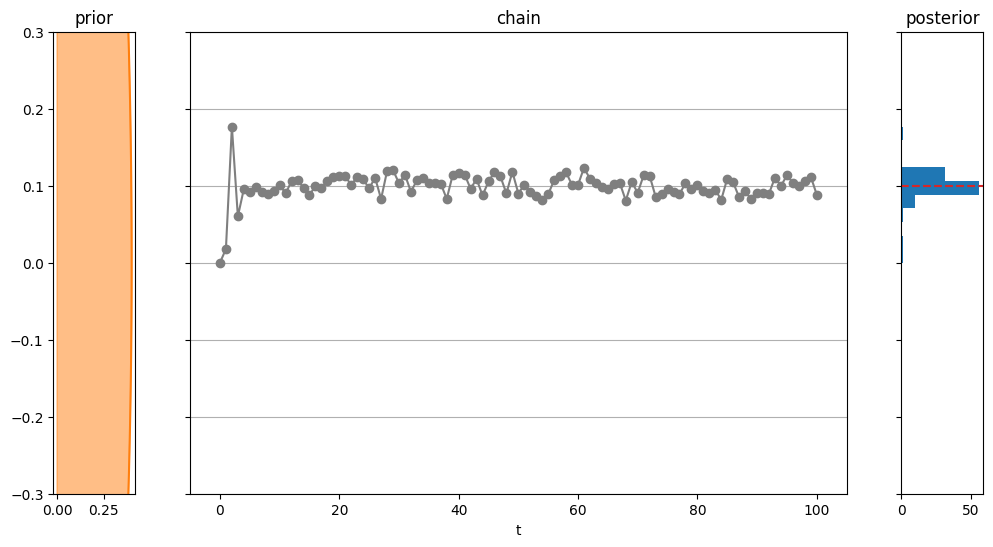

In [12]:
fig, axs, line, bars = plot_chain(chain);

In [13]:
def get_animation(fig, axs, line, bars):

    def update(i):
        line.set_data(np.arange(i), chain[:i])
        patches = bars.patches
        counts, bins = np.histogram(chain[:i], bins=len(patches))
        heights = np.diff(bins)

        for patch, count, y, height in zip(patches, counts, bins[:-1], heights):
            patch.set_y(y)
            patch.set_height(height)
            patch.set_width(count)

        return [line, *patches]

    return FuncAnimation(
        fig, update,
        frames=len(chain),
        blit=True,
        repeat=False,
        interval=1/100
    )

anima = get_animation(fig, axs, line, bars)

HTML(anima.to_jshtml(fps=30))

## References

### Links

- https://en.wikipedia.org/wiki/Calculus_of_variations
- https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm
- https://pyro.ai/examples/intro_long.html
- https://www.toptal.com/developers/algorithms/metropolis-hastings-bayesian-inference

### Papers

- [Hoffman et al.: Stochastic Variational Inference (2013)](https://doi.org/10.48550/arXiv.1206.7051)
- [Kingma and Welling: Auto-Encoding Variational Bayes (2022)](https://doi.org/10.48550/arXiv.1312.6114)
- [Metropolis et al.: Equation of State Calculations by Fast Computing Machines (1953)](https://doi.org/10.2172/4390578)

### Bibliography

```bib
@techreport{osti_4390578,
  author       = {Metropolis, Nicholas and Rosenbluth, Arianna W. and Rosenbluth, Marshall N. and Teller, Augusta H. and Teller, Edward},
  title        = {Equation of state calculations by fast computing machines},
  institution  = {Los Alamos Scientific Lab., Los Alamos, NM (United States); Univ. of Chicago, IL (United States)},
  annote       = {},
  doi          = {10.2172/4390578},
  url          = {https://www.osti.gov/biblio/4390578},
  place        = {United States},
  year         = {1953},
  month        = {03}
}

@misc{hoffman2013stochasticvariationalinference,
      title={Stochastic Variational Inference}, 
      author={Matt Hoffman and David M. Blei and Chong Wang and John Paisley},
      year={2013},
      eprint={1206.7051},
      archivePrefix={arXiv},
      primaryClass={stat.ML},
url={https://arxiv.org/abs/1206.7051}, 
}

@misc{kingma2022autoencodingvariationalbayes,
      title={Auto-Encoding Variational Bayes}, 
      author={Diederik P Kingma and Max Welling},
      year={2022},
      eprint={1312.6114},
      archivePrefix={arXiv},
      primaryClass={stat.ML},
      url={https://arxiv.org/abs/1312.6114}, 
}
```